# 1. Simple tokenizer

In [1]:
import torch
from torch import nn
from utils.simple_tokenizer import SimpleTokenizer
%load_ext autoreload
%autoreload 2

In [2]:
# token화할 문자열
text = 'Hello, world!'

In [3]:
tokenizer = SimpleTokenizer()

sot_token = tokenizer.encoder["<|startoftext|>"]
eot_token = tokenizer.encoder["<|endoftext|>"]

tokens = [sot_token] + tokenizer.encode(text) + [eot_token]
result = torch.zeros(77, dtype=torch.long)
result[:len(tokens)] = torch.tensor(tokens)
result

tensor([49406,  3306,   267,  1002,   256, 49407,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])

In [4]:
embedding = nn.Embedding(num_embeddings=70000,embedding_dim=1024)

print(embedding.weight.shape)       # vocab_size * dim 만큼의 파라미터 (사실상 단일 행렬) 보유

print(embedding(result).shape)      # embedding에 result를 씌운 결과. result는 77개의 token을 갖고 있으므로, 77개의 token을 각각 1024 dim의 벡터로 바꿔주었음.

torch.Size([70000, 1024])
torch.Size([77, 1024])


# 2. Quick GELU

### 1) Official GELU
GELU : Gaussian Error Linear Units function
$$\text{GELU}(x) = x*\Phi(x)$$
$\Phi : \mathbb{R} \rightarrow [0,1]$, $\Phi(x) = P(X\leq x)$, $X\sim \mathcal{N}(0,1)$

### 2) approximation 1
$$\text{GELU}(x) = 0.5 * x * (1 + \text{Tanh}(\sqrt{2 / \pi} * (x + 0.044715 * x^3)))$$

### 3) approximation 2
$$\text{GELU}(x) = x * \sigma(1.702 * x)$$
$\sigma(x) = 1/(1+e^{-z})$ sigmoid function

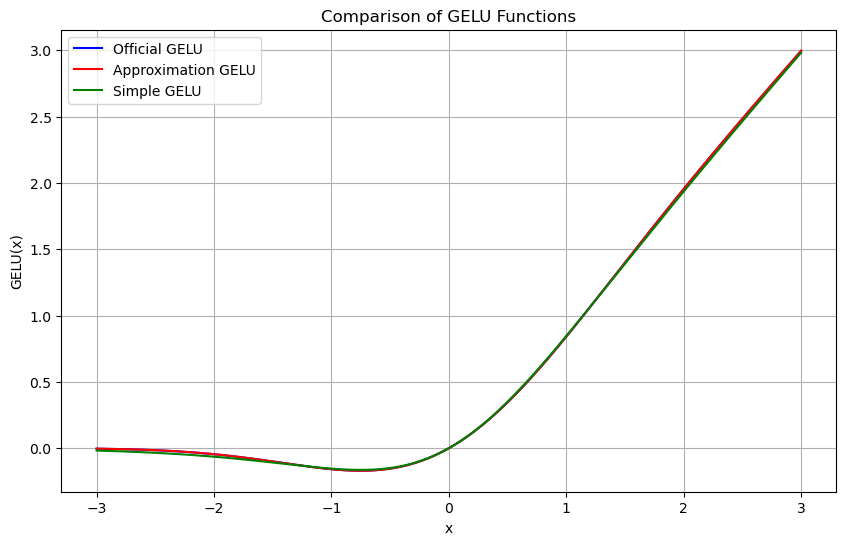

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the functions
def gelu(x):
    return x * norm.cdf(x)

def gelu_approx(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def gelu_simple(x):
    return x / (1 + np.exp(-1.702 * x))


x = np.linspace(-3, 3, 1000)


y_gelu = gelu(x)
y_gelu_approx_1 = gelu_approx(x)
y_gelu_approx_2 = gelu_simple(x)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y_gelu, label='Official GELU', color='blue')
plt.plot(x, y_gelu_approx_1, label='Approximation GELU', color='red')
plt.plot(x, y_gelu_approx_2, label='Simple GELU', color='green')
plt.xlabel('x')
plt.ylabel('GELU(x)')
plt.title('Comparison of GELU Functions')
plt.legend()
plt.grid(True)
plt.show()

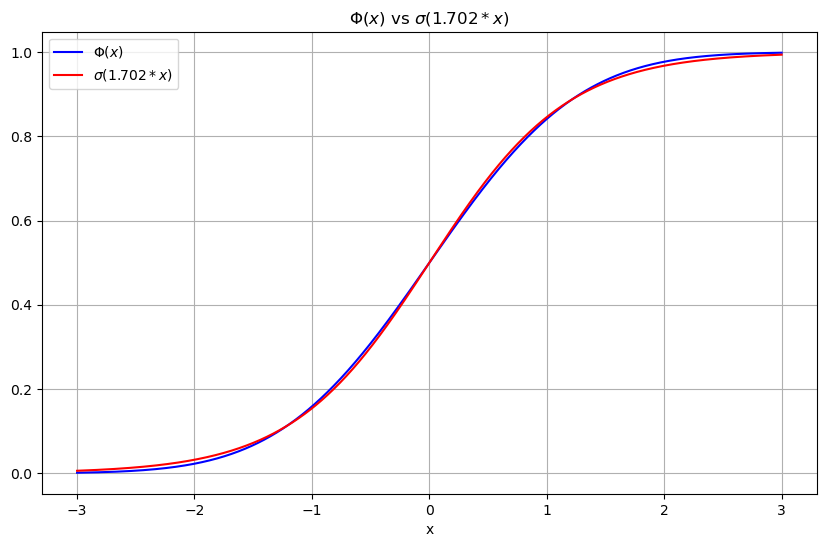

In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

x = np.linspace(-3, 3, 1000)


plt.figure(figsize=(10, 6))
plt.plot(x, [(lambda a : norm.cdf(a))(i) for i in x], label=r'$\Phi(x)$', color='blue')
plt.plot(x, [(lambda a : 1 / (1 + np.exp(-1.702 * a)))(i) for i in x], label=r'$\sigma(1.702*x)$', color='red')

plt.xlabel('x')
plt.title(r'$\Phi(x)$ vs $\sigma(1.702*x)$')
plt.legend()
plt.grid(True)
plt.show()

### CLIP에서는 approximation 2 식 사용